# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классификации комментариев на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Задачи:**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим библиотеки и данные

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

features_bert = pd.read_csv('features_bert.csv')
targets_bert = pd.read_csv('targets_bert.csv')

С BERT работал в colab


Ссылка на [Colab](https://colab.research.google.com/drive/1KExGm7O1vM-A2gL9yiH2imt2T2AKiGDz?usp=sharing 'Colab')

Осмотрим данные

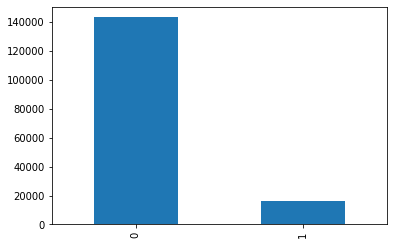

In [3]:
display(df.info(),
         f'Количество дубликатов: {df.duplicated().sum()}',
          df.head(),
           df['toxic'].value_counts().plot(kind='bar'))

Мы имеем неочищенные английские тексты, без дубликатов и пропусков, а так же сильным дисбалансом классов

## Предобработка

Очистим тексты с помощью регулярных выражений и проведем стемминг 

In [4]:
corpus = df['text']

def clear_text(text):
    text = text.lower()    
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    
    return text

def stemm_text(text):
    stemmer = nltk.SnowballStemmer("english")
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text


In [5]:
clear = corpus.apply(clear_text)
df['clear_text'] = clear.apply(stemm_text)
df.sample(5)

Разделим данные на обучающую и тестовую выборки и понизим размерность выборок

In [6]:
features = df['clear_text']
targets = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=.2, stratify=targets)

def downsample(features_train, target_train, fraction):
    features_zeros = features[targets == 0]
    features_ones = features[targets == 1]
    target_zeros = targets[targets == 0]
    target_ones = targets[targets == 1]
    features_downsampled = pd.concat(
    [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

fraction = round(y_train.value_counts().values[1] / y_train.value_counts().values[0], 5)
X_train, y_train = downsample(X_train, y_train, fraction)

display(X_train.shape, y_train.shape, y_train.value_counts())

## Обучение

### TF IDF

Обучим модели по сетке

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1))),
    ("model", LogisticRegression())
    
])

params = [
    {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'model': [LogisticRegression(max_iter=1000, C=10, solver='liblinear', random_state=42)]
     }
]

In [8]:
grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, n_jobs=-1)

In [9]:
%%time
grid.fit(X_train, y_train)
display(grid.best_estimator_, grid.best_score_)

In [10]:
def metrics(X, y, pred, model):
    print('F1 =', f1_score(y, pred))
    ax = sns.heatmap(confusion_matrix(y, pred), annot=True, cmap='Blues', fmt='d')

    ax.set_title('Матрица ошибок\n\n')
    ax.set_xlabel('\nПредсказания')
    ax.set_ylabel('Правильные ответы ')

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

In [11]:
tfidf_model = grid.best_estimator_
tfidf_model.fit(X_train, y_train)
tfidf_pred = tfidf_model.predict(X_test)

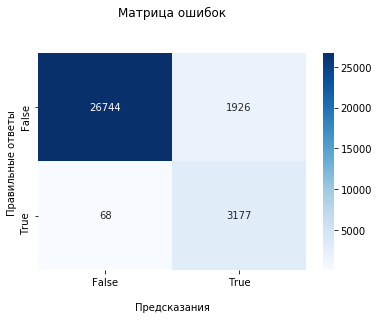

In [12]:
metrics(X_test, y_test, tfidf_pred, tfidf_model)

### BERT

Обучим модели на данных после BERT

In [13]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(features_bert, targets_bert, test_size=.2, stratify=targets_bert)

In [20]:
pipe = Pipeline([
    ("model", LogisticRegression())
])

params = [
    {
        'model': [LogisticRegression(max_iter=1000, C=10, solver='liblinear', random_state=42)]
    }, {
        'model': [LGBMClassifier(random_state=42)]
    }, {
        'model': [CatBoostClassifier(silent=True, random_state=42)]
     }
]

In [21]:
grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, n_jobs=-1)

In [22]:
%%time
grid.fit(X_train_bert, y_train_bert)
display(grid.best_estimator_, grid.best_score_)

In [23]:
bert_model = grid.best_estimator_
bert_model.fit(X_train_bert, y_train_bert)
bert_pred = bert_model.predict(X_test_bert)

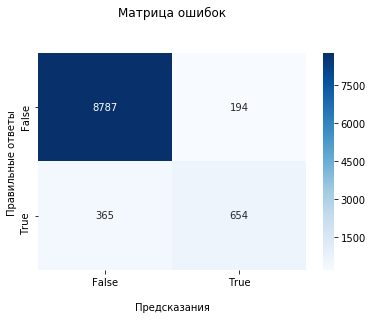

In [24]:
metrics(X_test_bert, y_test_bert, bert_pred, bert_model)

## Выводы

В ходе работы были получены данные без пропусков и дубликатов с сильным дисбалансом классов. Была повышена размерность выборки, очистка и кодирование данных. Были построены две модели: 
- Логистическая регрессия + TF IDF
- Логистическая регрессия + BERT

Модель на основе TF IDF прошла порог F1, модель на основе BERT не дотянула около 0.05.